In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, KFold, cross_val_score, StratifiedKFold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer

In [17]:
hist_dir = './denormalized'

In [18]:
results_dict = {'19-COMP-004': 1, '19-COMP-011': 1, '19-COMP-012': 1, '19-COMP-014': 1,
                '19-COMP-016': 1, '19-COMP-019': 1, '19-COMP-026': 1, '19-COMP-029': 1,
                '19-COMP-030': 1, '19-COMP-032': 1, '19-COMP-034': 1, '19-COMP-037': 1,
                '20-COMP-050': 1, '20-COMP-052': 1, '20-COMP-054': 1, '20-COMP-071': 1,
                '20-COMP-088': 1, '20-COMP-102': 1, '20-COMP-103': 1, '20-COMP-113': 1,
                '19-COMP-017': 0, '19-COMP-020': 0, '19-COMP-021': 0, '19-COMP-036': 0,
                '19-COMP-039': 0, '19-COMP-044': 0, '19-COMP-047': 0, '20-COMP-055': 0,
                '20-COMP-056': 0, '20-COMP-059': 0, '20-COMP-063': 0, '20-COMP-065': 0,
                '20-COMP-066': 0, '20-COMP-068': 0, '20-COMP-070': 0, '20-COMP-073': 0,
                '20-COMP-075': 0, '20-COMP-076': 0, '20-COMP-077': 0, '20-COMP-078': 0}

In [19]:
tr_set = ['19-COMP-004', '19-COMP-011', '19-COMP-012', '19-COMP-014', '19-COMP-016',
          '19-COMP-019', '19-COMP-029', '19-COMP-030', '19-COMP-032', '19-COMP-034',
          '20-COMP-050', '20-COMP-052', '20-COMP-054', '20-COMP-071', '20-COMP-088',
          '20-COMP-103', '20-COMP-113', '19-COMP-017', '19-COMP-020', '19-COMP-021',
          '19-COMP-044', '19-COMP-047', '20-COMP-055', '20-COMP-056', '20-COMP-059',
          '20-COMP-063', '20-COMP-066', '20-COMP-068', '20-COMP-070', '20-COMP-073',
          '20-COMP-075', '20-COMP-076', '20-COMP-078']

ts_set = ['20-COMP-077', '20-COMP-065', '19-COMP-039', '20-COMP-102', '19-COMP-037', '19-COMP-026']

In [20]:
def add_padding(hist):
  return np.pad(hist, (0, 100-len(hist)), 'constant')

In [21]:
def get_log_hist(hist):
    log_hist = np.log10(hist)
    #min_bin = np.min(log_hist)
    
    #log_hist = log_hist - min_bin
    #min_bin = np.min(hist)
    #if min_bin > 0:
     # min_bin = 0
    #log_hist = np.log10(hist-min_bin+1)
    return log_hist

Import histograms with log scale and padding to 100 bins and their targets

In [22]:
num_bins = 100

#Training set
padded_log_histograms_tr = []
log_histograms_tr = []
histograms_tr = []
for i, slide_name in enumerate(tr_set):
  histograms_tr.append((np.load(hist_dir+'/'+slide_name+'_bins_denorm_100r0.95.npy')))
  #padded_log_histograms_tr.append(add_padding(log_histograms_tr[i]))
  padded_log_histograms_tr.append(add_padding(get_log_hist(np.load(hist_dir+'/'+slide_name+'_bins_denorm_100r0.95.npy'))))
  print(slide_name)

targets_tr = np.zeros(np.shape(tr_set), dtype='int')
for i, slide_name in enumerate(tr_set):
  targets_tr[i] = results_dict[slide_name]

# Test set
padded_log_histograms_ts = []
log_histograms_ts = []
histograms_ts = []

for i, slide_name in enumerate(ts_set):
  histograms_ts.append((np.load(hist_dir+'/'+slide_name+'_bins_denorm_100r0.95.npy')))
  #padded_log_histograms_ts.append(add_padding(log_histograms_ts[i]))
  padded_log_histograms_ts.append(add_padding(get_log_hist(np.load(hist_dir+'/'+slide_name+'_bins_denorm_100r0.95.npy'))))
  print(slide_name)

targets_ts = np.zeros(np.shape(ts_set), dtype='int')
for i, slide_name in enumerate(ts_set):
  targets_ts[i] = results_dict[slide_name]

19-COMP-004
19-COMP-011
19-COMP-012
19-COMP-014
19-COMP-016
19-COMP-019
19-COMP-029
19-COMP-030
19-COMP-032
19-COMP-034
20-COMP-050
20-COMP-052
20-COMP-054
20-COMP-071
20-COMP-088
20-COMP-103
20-COMP-113
19-COMP-017
19-COMP-020
19-COMP-021
19-COMP-044
19-COMP-047
20-COMP-055
20-COMP-056
20-COMP-059
20-COMP-063
20-COMP-066
20-COMP-068
20-COMP-070
20-COMP-073
20-COMP-075
20-COMP-076
20-COMP-078
20-COMP-077
20-COMP-065
19-COMP-039
20-COMP-102
19-COMP-037
19-COMP-026


Show slides log + padded histograms

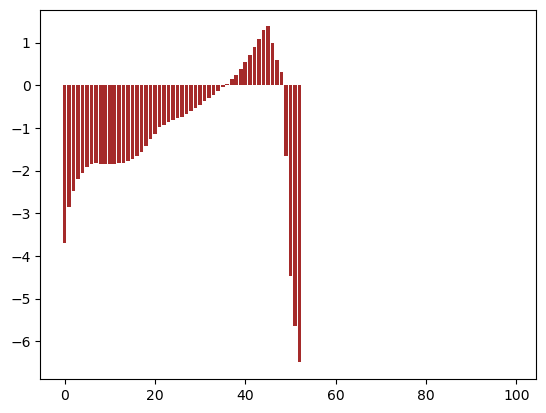

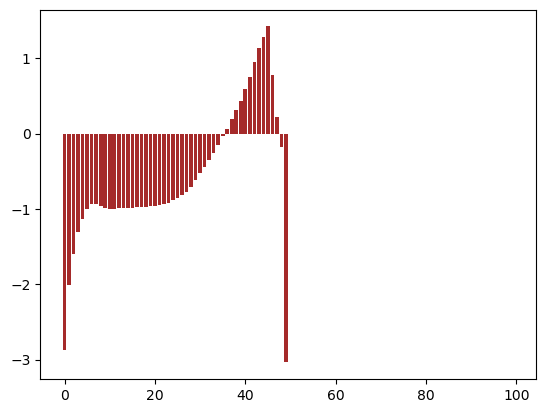

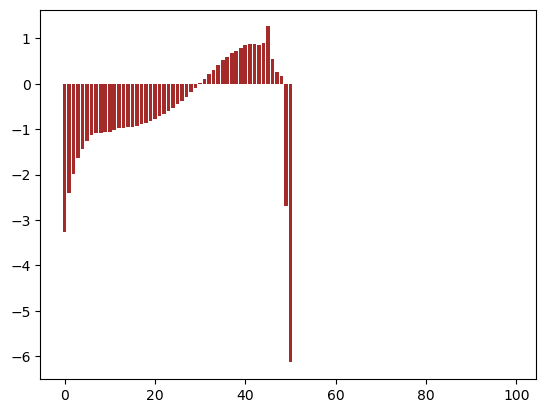

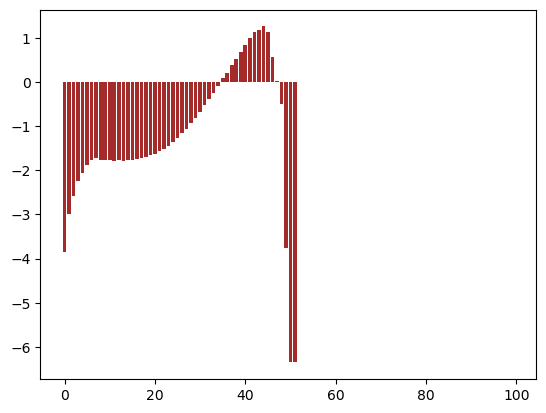

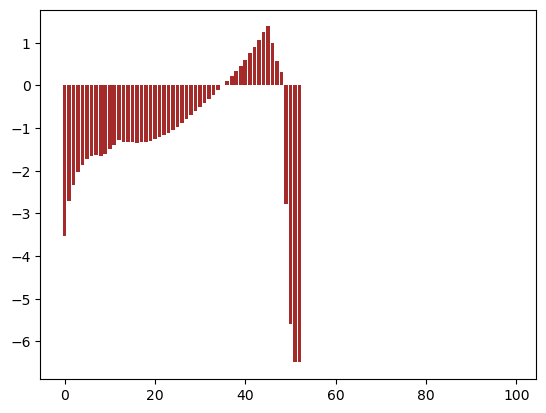

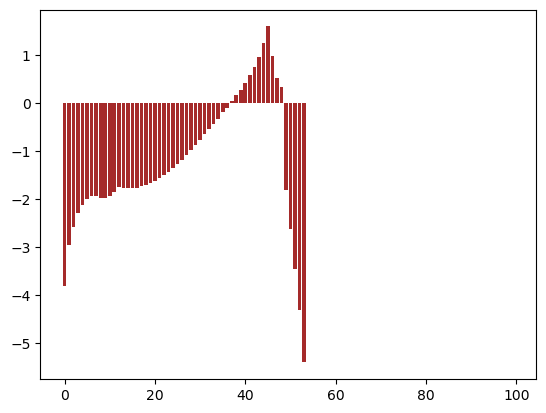

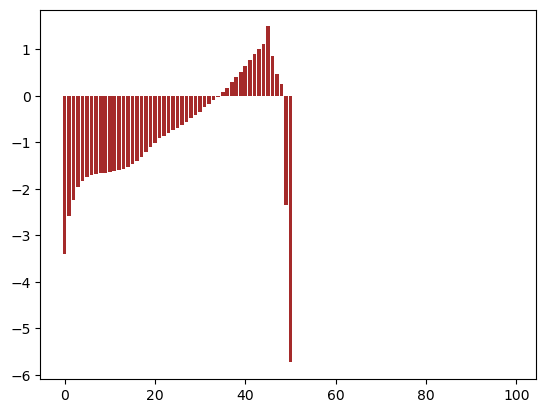

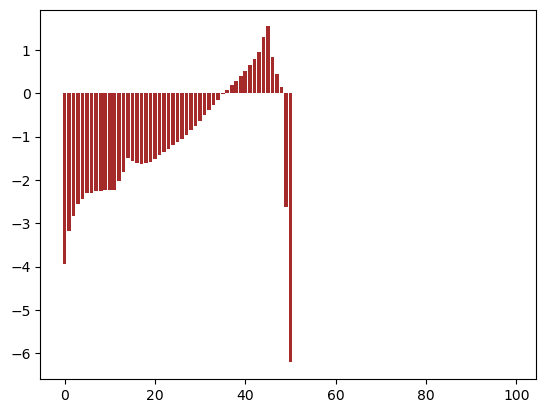

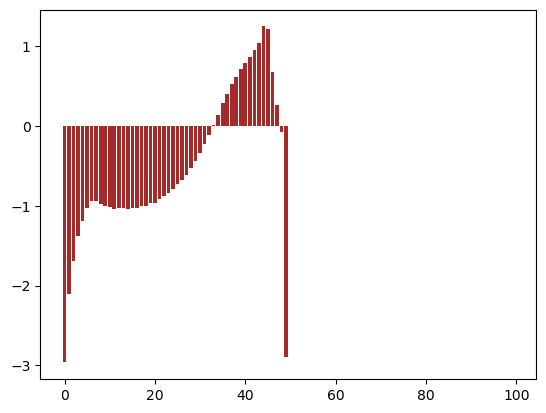

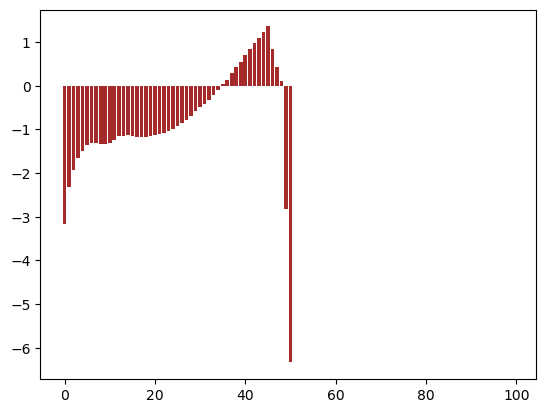

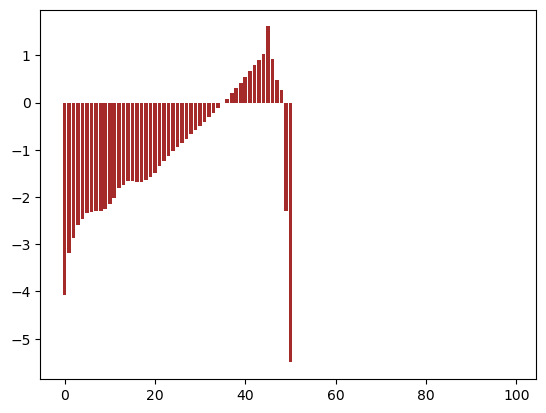

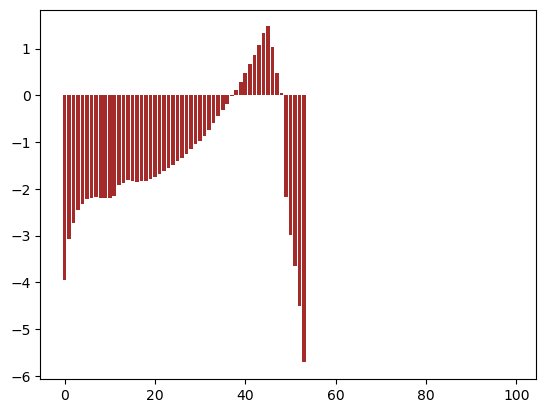

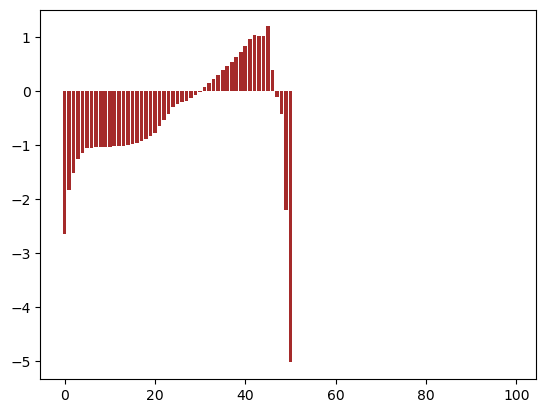

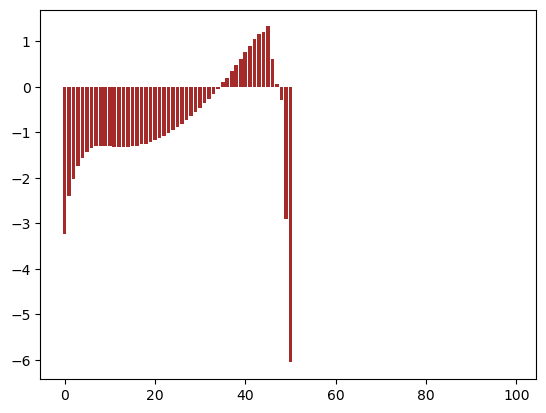

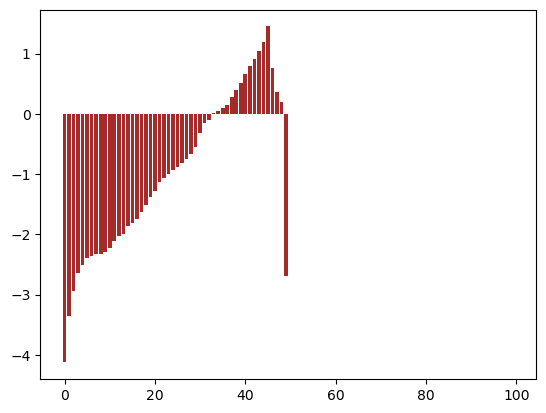

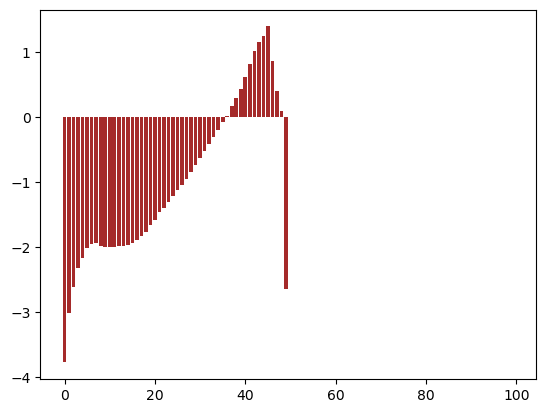

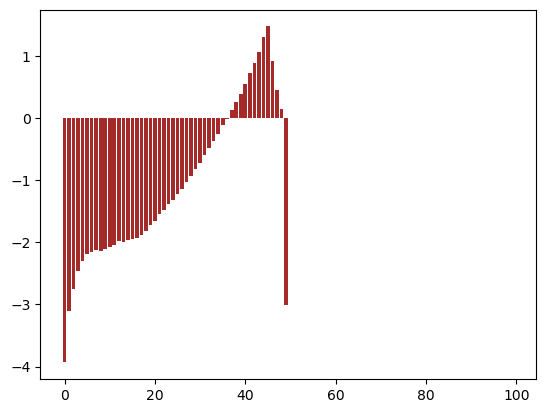

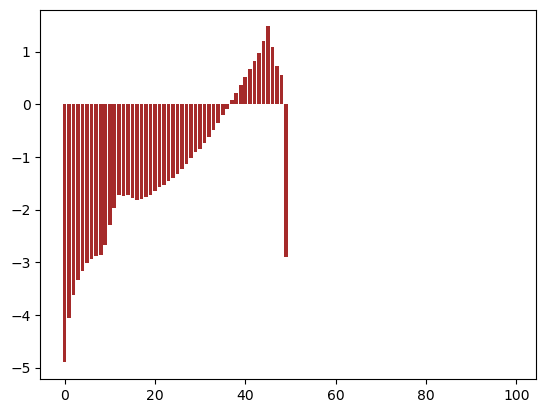

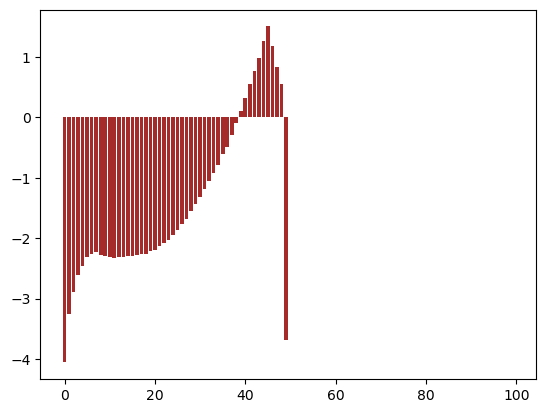

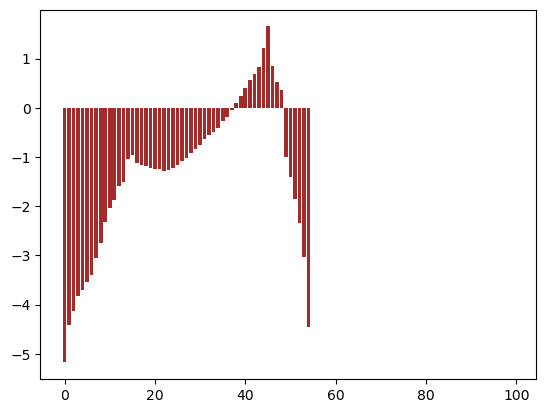

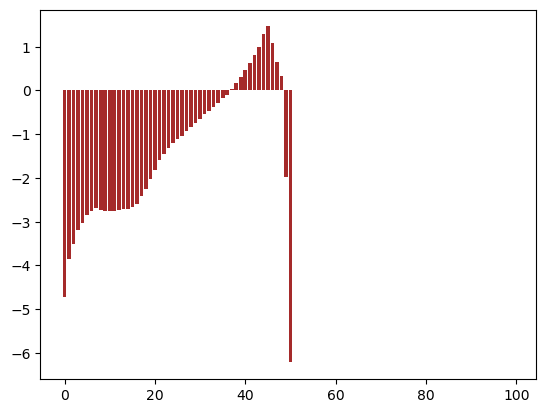

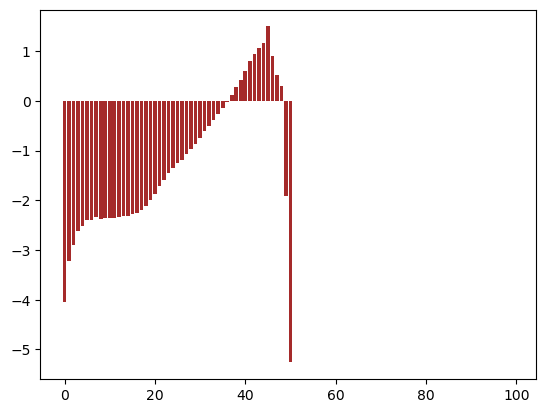

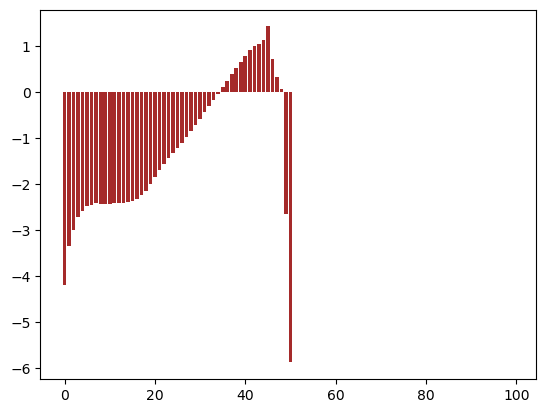

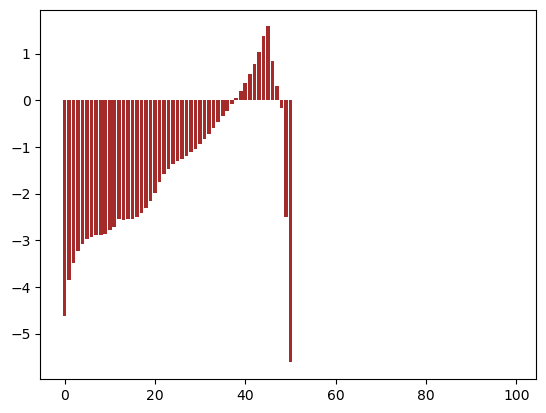

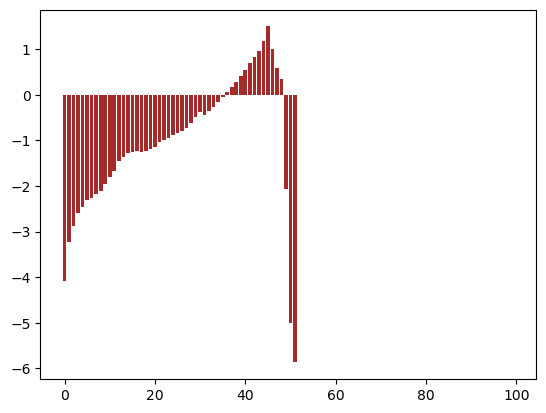

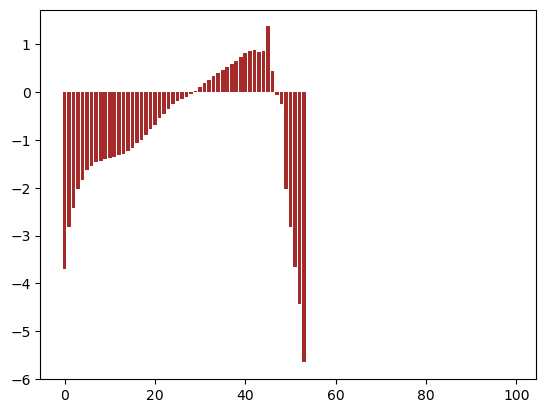

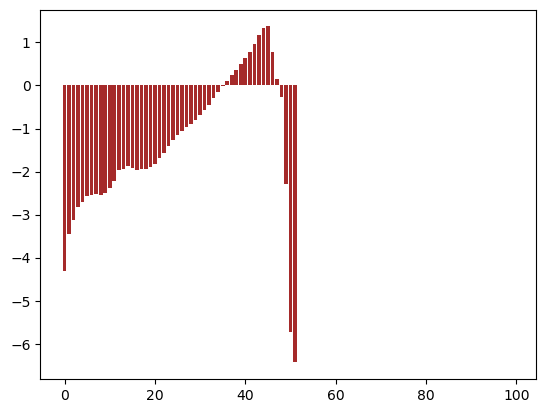

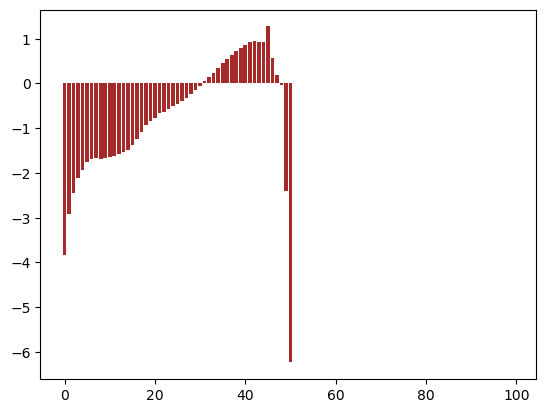

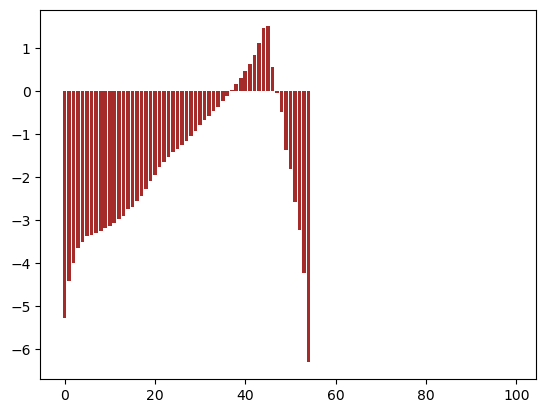

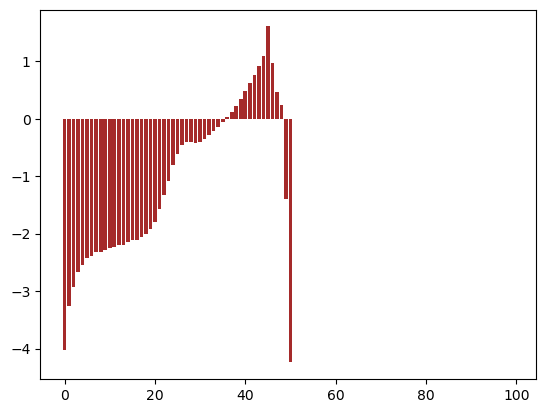

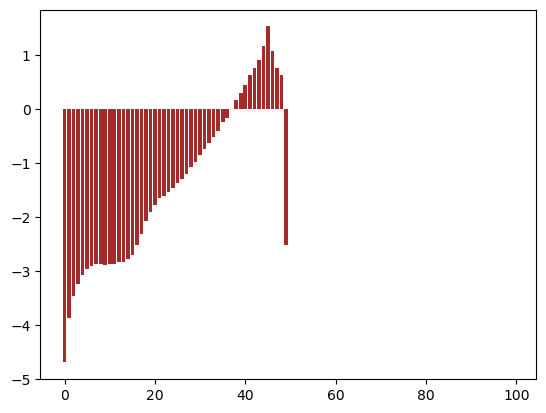

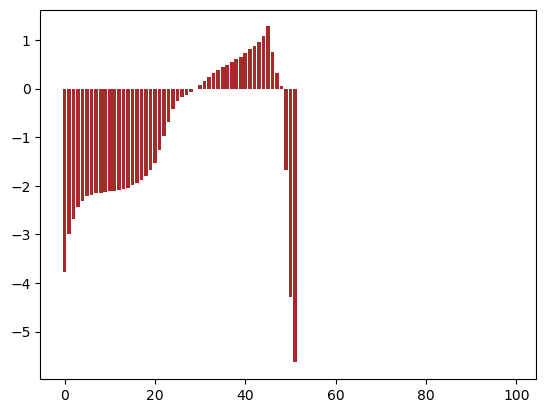

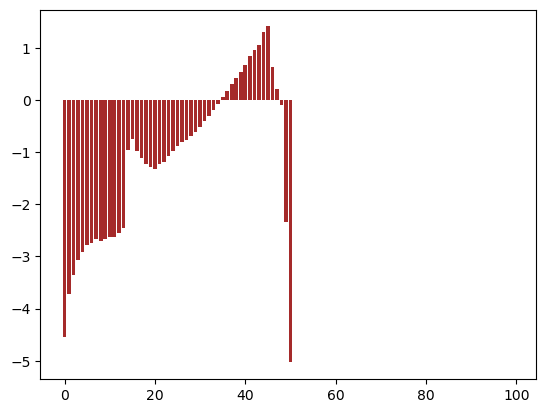

In [23]:
for i,slide_name in enumerate(tr_set):    
    plt.bar(x=range(len(padded_log_histograms_tr[i])), height=padded_log_histograms_tr[i], color='brown')
    plt.show()

SVM

In [24]:
def build_SVM(X, y, cv=6, print_res=True):
    params = [
    {"kernel": ["rbf", "linear", "sigmoid", "poly"], "gamma": ["scale", "auto"], "C": [0.1, 1, 10, 100, 300, 1000]},
    {"kernel": ["poly"], "degree": [2,3,4], "gamma": ["scale", "auto"], "C": [0.1, 1, 10, 100, 300, 1000]},

    ] 
    clf = GridSearchCV(svm.SVC(), params, refit = True, cv=cv)
    clf.fit(X, y)
    if print_res:
      print("SVM - Best parameters set found:")
      print(clf.best_params_)
      print("SVM - Best score found:")
      print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

Random forest

In [25]:
def build_random_forest(X, y, cv=6, print_res=True):
    params = [{
    'bootstrap': [True, False],
    'max_depth': [100, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2],
    #'min_samples_split': [2, 4, 8],
    'n_estimators': [100, 500, 1000]
    }] 
    clf = GridSearchCV(RandomForestClassifier(), params, refit = True, cv=cv)
    clf.fit(X, y)
    if print_res:
      print("RF - Best parameters set found:")
      print(clf.best_params_)
      print("RF - Best score found:")
      print(clf.best_score_)
    
    return(clf.best_score_, clf.best_estimator_)

Decision Tree

In [26]:
def build_decision_tree(X, y, cv=6, print_res=True):
  dt = DecisionTreeClassifier()
  scores = cross_val_score(dt, X, y, cv=cv)
  score = sum(scores)/len(scores)
  if print_res:
    print('DT- Score:',score)
  #retrain
  dt.fit(X, y)
  return(score, dt)

In [27]:
scores_table_tr = np.zeros((3, 3))

# Test

In [28]:
def test_model(model, dataset):
  y_pred = model.predict(dataset)
  score = accuracy_score(targets_ts, y_pred)
  errors = np.size(ts_set) - accuracy_score(targets_ts, y_pred, normalize=False)
  return (score, y_pred, errors)

# Nested K-fold CV

In [29]:
total_pad_log_internal = np.concatenate((padded_log_histograms_tr, padded_log_histograms_ts), axis=0)

total_y_internal = np.concatenate((targets_tr, targets_ts))

In [30]:
X = total_pad_log_internal

y = total_y_internal
num_trials = 1
n_splits = 6

cv_svms = []
cv_rfs = []
cv_dts = []

acc_scores_svm = []
acc_scores_rf = []
acc_scores_dt = []

f1_scores_svm = []
f1_scores_rf = []
f1_scores_dt = []

f1_weight_scores_svm = []
f1_weight_scores_rf = []
f1_weight_scores_dt = []

outer_cv = KFold(n_splits=n_splits, shuffle=True)
# enumerate splits
for train_index, test_index in outer_cv.split(X):
  X_train, X_test = X[train_index, :], X[test_index, :]
  y_train, y_test = y[train_index], y[test_index]
  inner_cv = KFold(n_splits=n_splits-1, shuffle=True)
	
  #SVM
  _, nested_svm = build_SVM(X_train, y_train, cv=inner_cv, print_res=False)
  cv_svms.append(nested_svm)
  pred = nested_svm.predict(X_test)
  acc_scores_svm.append(accuracy_score(y_test, pred))
  f1_scores_svm.append(f1_score(y_test, pred))
  f1_weight_scores_svm.append(f1_score(y_test, pred, average="weighted"))



  #RF
  _, nested_rf = build_random_forest(X_train, y_train, cv=inner_cv, print_res=False)
  cv_rfs.append(nested_rf)
  pred = nested_rf.predict(X_test)
  acc_scores_rf.append(accuracy_score(y_test, pred))
  f1_scores_rf.append(f1_score(y_test, pred))
  f1_weight_scores_rf.append(f1_score(y_test, pred, average="weighted"))


  #DT
  _, nested_dt = build_decision_tree(X_train, y_train, cv=inner_cv, print_res=False)
  cv_dts.append(nested_dt)
  pred = nested_dt.predict(X_test)
  acc_scores_dt.append(accuracy_score(y_test, pred))
  f1_scores_dt.append(f1_score(y_test, pred))
  f1_weight_scores_dt.append(f1_score(y_test, pred, average="weighted"))


In [31]:
avg_acc_svm = np.average(acc_scores_svm)
print('acc_scores_svm:', acc_scores_svm)
print('avg_acc_svm:', avg_acc_svm)
avg_f1_svm = np.average(f1_scores_svm)
print('f1_scores_svm:', f1_scores_svm)
print('avg_f1_svm:', avg_f1_svm)
avg_f1_weight_svm = np.average(f1_weight_scores_svm)
print('f1_weight_scores_svm:', f1_weight_scores_svm)
print('avg_f1_weight_svm:', avg_f1_weight_svm)
print('\n')

avg_acc_rf = np.average(acc_scores_rf)
print('acc_scores_rf:', acc_scores_rf)
print('avg_acc_rf:', avg_acc_rf)
avg_f1_rf = np.average(f1_scores_rf)
print('f1_scores_rf:', f1_scores_rf)
print('avg_f1_rf:', avg_f1_rf)
avg_f1_weight_rf = np.average(f1_weight_scores_rf)
print('f1_weight_scores_rf:', f1_weight_scores_rf)
print('avg_f1_weight_rf:', avg_f1_weight_rf)
print('\n')

avg_acc_dt = np.average(acc_scores_dt)
print('acc_scores_dt:', acc_scores_dt)
print('avg_acc_dt:', avg_acc_dt)
avg_f1_dt = np.average(f1_scores_dt)
print('f1_scores_dt:', f1_scores_dt)
print('avg_f1_dt:', avg_f1_dt)
avg_f1_weight_dt = np.average(f1_weight_scores_dt)
print('f1_weight_scores_dt:', f1_weight_scores_dt)
print('avg_f1_weight_dt:', avg_f1_weight_dt)
print('\n')

acc_scores_svm: [0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.5, 0.8333333333333334, 0.6666666666666666]
avg_acc_svm: 0.7142857142857143
f1_scores_svm: [0.75, 0.8571428571428571, 0.6666666666666666, 0.5714285714285715, 0.8571428571428571, 0.75]
avg_f1_svm: 0.7420634920634921
f1_weight_scores_svm: [0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.45714285714285713, 0.8380952380952381, 0.6666666666666666]
avg_f1_weight_svm: 0.707936507936508


acc_scores_rf: [0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.6666666666666666, 0.3333333333333333, 0.8333333333333334]
avg_acc_rf: 0.7103174603174603
f1_scores_rf: [0.75, 0.8571428571428571, 0.8, 0.6666666666666666, 0.3333333333333333, 0.888888888888889]
avg_f1_rf: 0.7160052910052911
f1_weight_scores_rf: [0.7142857142857143, 0.8571428571428571, 0.8507936507936508, 0.6666666666666666, 0.3333333333333333, 0.8148148148148149]
avg_f1_weight_rf: 0.7061728395061729


acc_scores_dt: [0.5714285714285714, 0.857

# External dataset

In [32]:
hist_dir_ext = './denormalized_ext'

In [33]:
results_dict_ext = {'M-180-20-A1 SP142': 0, 'M-3784-20-A1 SP142': 1, 'M-3905-20 SP142 (1)': 1, 'M-534-20-1 SP142': 1, 'M-834-21 SP142': 1,
 'M-1163-20 SP142': 0, 'M-1242-20 SP142': 0, 'M-180-20 (3) B1': 0, 'M-182-20-A1 SP142': 0, 'M-313-20 SP142': 0, 'M-3454-20-A1 SP142': 0,
 'M-3587-20 SP142': 0, 'M-360-20 SP142': 0, 'M-3760-20-A1 SP142': 0, 'M-3914-20 SP142 (2)': 0, 'M-4075-20 SP142 (2)': 0,
 'M-4092-20 SP142 (2)': 0, 'M-5248-20 SP142 (1)': 0, 'M-527-20 MA1-SP142': 0, 'M-527-20 MA2-SP142': 0, 'M-5428-20 SP142': 0,
 'M-5696-20 (3)': 0, 'M-5697-20 SP142': 0, 'M-6014-20 A1-SP142': 0, 'M-6052-20 A1-SP142': 0, 'M-67-21-1-SP142 (4)': 0}

In [34]:
ext_set = ['M-180-20-A1 SP142', 'M-3784-20-A1 SP142', 'M-3905-20 SP142 (1)', 'M-534-20-1 SP142', 'M-834-21 SP142',
              'M-1163-20 SP142', 'M-1242-20 SP142', 'M-180-20 (3) B1', 'M-182-20-A1 SP142', 'M-313-20 SP142', 'M-3454-20-A1 SP142',
              'M-3587-20 SP142', 'M-360-20 SP142', 'M-3760-20-A1 SP142', 'M-3914-20 SP142 (2)', 'M-4075-20 SP142 (2)',
              'M-4092-20 SP142 (2)', 'M-5248-20 SP142 (1)', 'M-527-20 MA1-SP142', 'M-527-20 MA2-SP142', 'M-5428-20 SP142',
              'M-5696-20 (3)', 'M-5697-20 SP142', 'M-6052-20 A1-SP142', 'M-67-21-1-SP142 (4)']

In [35]:
num_bins = 100

# External test set
padded_log_histograms_ext = []
log_histograms_ext = []
histograms_ext = []

for i, slide_name in enumerate(ext_set):
  histograms_ext.append((np.load(hist_dir_ext+'/'+slide_name+'_bins_denorm_100r0.95.npy')))
  padded_log_histograms_ext.append(add_padding(get_log_hist(np.load(hist_dir_ext+'/'+slide_name+'_bins_denorm_100r0.95.npy'))))
  print(slide_name)

targets_ext = np.zeros(np.shape(ext_set), dtype='int')
for i, slide_name in enumerate(ext_set):
  targets_ext[i] = results_dict_ext[slide_name]

M-180-20-A1 SP142
M-3784-20-A1 SP142
M-3905-20 SP142 (1)
M-534-20-1 SP142
M-834-21 SP142
M-1163-20 SP142
M-1242-20 SP142
M-180-20 (3) B1
M-182-20-A1 SP142
M-313-20 SP142
M-3454-20-A1 SP142
M-3587-20 SP142
M-360-20 SP142
M-3760-20-A1 SP142
M-3914-20 SP142 (2)
M-4075-20 SP142 (2)
M-4092-20 SP142 (2)
M-5248-20 SP142 (1)
M-527-20 MA1-SP142
M-527-20 MA2-SP142
M-5428-20 SP142
M-5696-20 (3)
M-5697-20 SP142
M-6052-20 A1-SP142
M-67-21-1-SP142 (4)


Majority vote between nested cv models, otherwise weighted vote by accuracy

In [36]:
def ensemble_majority_weighted(X, y, models_arr, acc_arr):
  pred_table = np.zeros((len(models_arr), len(y)))
  for i, model in enumerate(models_arr):
    y_pred = model.predict(X)
    pred_table[i, :] = y_pred

  final_preds = np.zeros(len(y))

  for j in range(len(y)):
    avg = (np.average(pred_table[:, j]))
    if avg == 0.5:
      avg = np.average(pred_table[:, j], weights=acc_arr)
    final_preds[j] = (avg > 0.5).astype('int')
  
  acc = accuracy_score(y, final_preds)
  f1 = f1_score(y, final_preds)
  f1_wieght = f1_score(y, final_preds, average="weighted")

  tn, fp, fn, tp = confusion_matrix(y, final_preds).ravel()

  return acc, f1, f1_wieght, tn, fp, fn, tp

In [37]:
X = padded_log_histograms_ext
y = targets_ext

acc_svm_ext, f1_svm_ext, f1_weight_svm_ext, tn, fp, fn, tp = ensemble_majority_weighted(X, y, cv_svms, acc_scores_svm)
print('acc_svm_ext:', acc_svm_ext)
print('f1_svm_ext:', f1_svm_ext)
print('f1_weight_svm_ext:', f1_weight_svm_ext)
print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp)
print('\n')

acc_rf_ext, f1_rf_ext, f1_weight_rf_ext, tn, fp, fn, tp = ensemble_majority_weighted(X, y, cv_rfs, acc_scores_rf)
print('acc_rf_ext:', acc_rf_ext)
print('f1_rf_ext:', f1_rf_ext)
print('f1_weight_rf_ext:', f1_weight_rf_ext)
print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp)

print('\n')

acc_dt_ext, f1_dt_ext, f1_weight_dt_ext, tn, fp, fn, tp = ensemble_majority_weighted(X, y, cv_dts, acc_scores_dt)
print('acc_dt_ext:', acc_dt_ext)
print('f1_dt_ext:', f1_dt_ext)
print('f1_weight_dt_ext:', f1_weight_dt_ext)
print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp)

acc_svm_ext: 0.64
f1_svm_ext: 0.39999999999999997
f1_weight_svm_ext: 0.6880000000000002
tn: 13 fp: 8 fn: 1 tp: 3


acc_rf_ext: 0.76
f1_rf_ext: 0.4
f1_weight_rf_ext: 0.7780000000000001
tn: 17 fp: 4 fn: 2 tp: 2


acc_dt_ext: 0.76
f1_dt_ext: 0.4
f1_weight_dt_ext: 0.7780000000000001
tn: 17 fp: 4 fn: 2 tp: 2


# Combined internal + ext datasets

In [38]:
total_pad_log = np.concatenate((padded_log_histograms_tr, padded_log_histograms_ts, padded_log_histograms_ext), axis=0)
total_targets = np.concatenate((total_y_internal, targets_ext), axis=0)

In [39]:
X = total_pad_log

y = total_targets
num_trials = 1
n_splits = 6

cv_svms = []
cv_rfs = []
cv_dts = []

acc_scores_svm = []
acc_scores_rf = []
acc_scores_dt = []

f1_scores_svm = []
f1_scores_rf = []
f1_scores_dt = []

f1_weight_scores_svm = []
f1_weight_scores_rf = []
f1_weight_scores_dt = []

outer_cv = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state=1)

# enumerate splits
for train_index, test_index in outer_cv.split(X, y):
  X_train, X_test = X[train_index, :], X[test_index, :]
  y_train, y_test = y[train_index], y[test_index]
  inner_cv = StratifiedKFold(n_splits=n_splits-1, shuffle=True, random_state=1)
	
  #SVM
  _, nested_svm = build_SVM(X_train, y_train, cv=inner_cv, print_res=False)
  cv_svms.append(nested_svm)
  pred = nested_svm.predict(X_test)
  acc_scores_svm.append(accuracy_score(y_test, pred))
  f1_scores_svm.append(f1_score(y_test, pred))
  f1_weight_scores_svm.append(f1_score(y_test, pred, average="weighted"))



  #RF
  _, nested_rf = build_random_forest(X_train, y_train, cv=inner_cv, print_res=False)
  cv_rfs.append(nested_rf)
  pred = nested_rf.predict(X_test)
  acc_scores_rf.append(accuracy_score(y_test, pred))
  f1_scores_rf.append(f1_score(y_test, pred))
  f1_weight_scores_rf.append(f1_score(y_test, pred, average="weighted"))


  #DT
  _, nested_dt = build_decision_tree(X_train, y_train, cv=inner_cv, print_res=False)
  cv_dts.append(nested_dt)
  pred = nested_dt.predict(X_test)
  acc_scores_dt.append(accuracy_score(y_test, pred))
  f1_scores_dt.append(f1_score(y_test, pred))
  f1_weight_scores_dt.append(f1_score(y_test, pred, average="weighted"))


In [40]:
avg_acc_svm = np.average(acc_scores_svm)
print('acc_scores_svm:', acc_scores_svm)
print('avg_acc_svm:', avg_acc_svm)
avg_f1_svm = np.average(f1_scores_svm)
print('f1_scores_svm:', f1_scores_svm)
print('avg_f1_svm:', avg_f1_svm)
avg_f1_weight_svm = np.average(f1_weight_scores_svm)
print('f1_weight_scores_svm:', f1_weight_scores_svm)
print('avg_f1_weight_svm:', avg_f1_weight_svm)
print('\n')

avg_acc_rf = np.average(acc_scores_rf)
print('acc_scores_rf:', acc_scores_rf)
print('avg_acc_rf:', avg_acc_rf)
avg_f1_rf = np.average(f1_scores_rf)
print('f1_scores_rf:', f1_scores_rf)
print('avg_f1_rf:', avg_f1_rf)
avg_f1_weight_rf = np.average(f1_weight_scores_rf)
print('f1_weight_scores_rf:', f1_weight_scores_rf)
print('avg_f1_weight_rf:', avg_f1_weight_rf)
print('\n')

avg_acc_dt = np.average(acc_scores_dt)
print('acc_scores_dt:', acc_scores_dt)
print('avg_acc_dt:', avg_acc_dt)
avg_f1_dt = np.average(f1_scores_dt)
print('f1_scores_dt:', f1_scores_dt)
print('avg_f1_dt:', avg_f1_dt)
avg_f1_weight_dt = np.average(f1_weight_scores_dt)
print('f1_weight_scores_dt:', f1_weight_scores_dt)
print('avg_f1_weight_dt:', avg_f1_weight_dt)
print('\n')

acc_scores_svm: [0.7272727272727273, 0.6363636363636364, 0.45454545454545453, 0.7272727272727273, 0.8, 0.8]
avg_acc_svm: 0.6909090909090909
f1_scores_svm: [0.6666666666666665, 0.3333333333333333, 0.5, 0.6666666666666665, 0.75, 0.8]
avg_f1_svm: 0.6194444444444444
f1_weight_scores_svm: [0.7319347319347319, 0.5984848484848485, 0.43636363636363645, 0.7319347319347319, 0.8, 0.8]
avg_f1_weight_svm: 0.683119658119658


acc_scores_rf: [0.7272727272727273, 0.5454545454545454, 0.5454545454545454, 0.6363636363636364, 0.6, 0.8]
avg_acc_rf: 0.6424242424242425
f1_scores_rf: [0.5714285714285715, 0.0, 0.28571428571428575, 0.6666666666666666, 0.5, 0.75]
avg_f1_rf: 0.46230158730158727
f1_weight_scores_rf: [0.7168831168831169, 0.4491978609625668, 0.5281385281385281, 0.6242424242424243, 0.6, 0.8]
avg_f1_weight_rf: 0.6197436550377727


acc_scores_dt: [0.8181818181818182, 0.36363636363636365, 0.6363636363636364, 0.6363636363636364, 0.6, 0.7]
avg_acc_dt: 0.6257575757575758
f1_scores_dt: [0.6666666666666666, 